# 3D recon with KP matching

In [1]:
import cv2
import numpy as np 
import stereo_setting as stset

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

### Global variables

In [2]:
grid_sz = 100
n_matches = 1000 
list_kp1 = []
list_kp2 = []
dense_kp1 = None
dense_kp2 = None

calib_dir = "./basler_calib_params_2022/"

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# create Brute-Force Matcher object
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

[ WARN:0@38.729] global /home/iamzainum/opencv_build/opencv_contrib/modules/xfeatures2d/misc/python/shadow_sift.hpp (13) SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


### Point matching

In [3]:
def kp_matching(rect_l, rect_r):
    # Find the keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(rect_l, None)
    kp2, des2 = sift.detectAndCompute(rect_r, None)
    
    # Match descriptors
    matches = bf.match(des1, des2)
    
    # Sort them in the order of their distance
    matches = sorted(matches, key = lambda x:x.distance)
    
    # Extract kpt locations from matched pts
    list_kp1 = np.asarray([kp1[mat.queryIdx].pt for mat in matches[:n_matches]])
    list_kp2 = np.asarray([kp2[mat.trainIdx].pt for mat in matches[:n_matches]])
    
    # Calculate the transformation matrix
    trans_mat = list_kp1 - list_kp2
    
    # Return image with drawn matches
    img_kps = cv2.drawMatches(rect_l, kp1, rect_r, kp2, matches[:n_matches], None, flags=2)
    vert, hori = img_kps.shape[:2]
    resize_scale = 3
    scaled = (int(hori/resize_scale), int(vert/resize_scale))
    img_kps = cv2.resize(img_kps, scaled)
    
    return list_kp1, list_kp2, img_kps, trans_mat
#enddef

### Rectifying images

In [4]:
def rectify_images(orig_l, orig_r, calib_dir):
    vert, hori = orig_l.shape[:2]
    left_stereo_map, right_stereo_map, _ = stset.st_maps(calib_dir, (hori, vert))
    rect_l, rect_r = stset.st_rectify(orig_l, orig_r, left_stereo_map, right_stereo_map)
    
    return rect_l, rect_r
#enddef

### Helper functions

In [5]:
def rounding_list(a):
    np_a = np.array(a)
    np_a = np.around(np_a, decimals=0)
    np_b = np_a.astype(int)
    return np_b
#enddef

### Disparity from KP

In [6]:
def calculateDisparityFromKP(list_kp1, list_kp2, dimen):
    disp_image = np.zeros((dimen[1], dimen[0]))
    np_kp1, np_kp2 = rounding_list(list_kp1), rounding_list(list_kp2)
    trans_mat = np_kp1 - np_kp2
    
    for kp in np_kp1:
        disp_image[kp[0]][kp[1]] = 255.0
    #next
    
    return disp_image
#enddef
            

### Main code

In [8]:
orig_l_dir = "./basler_L_data_2022/20_L_.png"
orig_r_dir = "./basler_R_data_2022/20_R_.png"
    
orig_l, orig_r = cv2.imread(orig_l_dir), cv2.imread(orig_r_dir)
    
rect_l, rect_r = rectify_images(orig_l, orig_r, calib_dir)
list_kp1, list_kp2, img_kps, trans_mat = kp_matching(rect_l, rect_r)
    
vert, hori = rect_l.shape[:2]
resize_scale = 3
scaled = (int(hori/resize_scale), int(vert/resize_scale))
    
#     print(trans_mat)
    
x_delta = int(np.floor(np.abs(np.mean(trans_mat[:,0]))))
y_delta = int(np.floor(np.abs(np.mean(trans_mat[:,1]))))
    
disp = calculateDisparityFromKP(list_kp1, list_kp2, (vert, hori))
    
cv2.imshow("disp", cv2.resize(disp, scaled))
cv2.imshow("rect_l", cv2.resize(rect_l, scaled))
cv2.imshow("img_kps", img_kps)
cv2.waitKey(0)
cv2.destroyAllWindows()
    
print(len(trans_mat))
#enddef

1000


In [9]:
a = [[533.8918457,577.56658936],[1106.21447754,917.39343262],[1233.07739258,960.89935303]]

np_a = np.array(a)
np_a = np.around(np_a, decimals=0)
np_b = np_a.astype(int)


print(np_b)

for i in a:
    print(i[0])
    print(i[1])

[[ 534  578]
 [1106  917]
 [1233  961]]
533.8918457
577.56658936
1106.21447754
917.39343262
1233.07739258
960.89935303


In [10]:
RL = np.load(calib_dir+'RL.npy')
PL = np.load(calib_dir+'PL.npy')
RR = np.load(calib_dir+'RR.npy')
PR = np.load(calib_dir+'PR.npy')

T = np.load(calib_dir+'T.npy')

print("PL => \n", PL,
      "\n\nPR => \n", PR, 
      "\n\nRL => \n", RL, 
      "\n\nRR => \n", RR, 
      "\n\nT => \n", T)

PL => 
 [[858.03758467   0.         856.36724091   0.        ]
 [  0.         858.03758467 606.02495575   0.        ]
 [  0.           0.           1.           0.        ]] 

PR => 
 [[8.58037585e+02 0.00000000e+00 8.56367241e+02 2.73912493e+05]
 [0.00000000e+00 8.58037585e+02 6.06024956e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]] 

RL => 
 [[ 0.99983943  0.0045455  -0.0173336 ]
 [-0.00476723  0.99990707 -0.0127719 ]
 [ 0.01727393  0.01285249  0.99976819]] 

RR => 
 [[ 0.99910288  0.00393787 -0.04216558]
 [-0.00339717  0.99991119  0.01288724]
 [ 0.04221258 -0.01273243  0.99902752]] 

T => 
 [[318.94495549]
 [  1.25709046]
 [-13.46057448]]


In [11]:
list_kp1.T

array([[ 917.29675293,  747.87084961, 1175.91503906, ...,  597.4586792 ,
        1209.87670898,  482.07025146],
       [ 880.59320068,  747.67053223,  783.66687012, ...,  522.79162598,
        1011.57885742,  930.41052246]])

In [12]:
def write_ply(fn, verts, colors):
    verts = verts.reshape(-1, 3)
    colors = colors.reshape(-1, 3)
    #verts, colors = filter_infinity(verts, colors)
    verts = np.hstack([verts, colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')
#enddef

In [13]:
X = cv2.triangulatePoints(PL, PR, list_kp1.T, list_kp2.T)
# Remember to divide out the 4th row. Make it homogeneous
Y = (X/X[3])[:3]
x, y, z = Y[0], Y[1], Y[2]

Y[1][:20]

array([ 434.4019125 ,  104.33812959,  166.03950892, -384.92553304,
        246.09472531, -395.63452884,  225.15154194, -139.89350958,
       -103.68585294,  139.91063151,  198.41875264,  104.33812959,
        247.75653515,    9.675669  ,   13.87267255,   95.20621187,
        105.511765  ,  143.7050187 ,  252.94799049,  212.51143947])

<IPython.core.display.Javascript object>


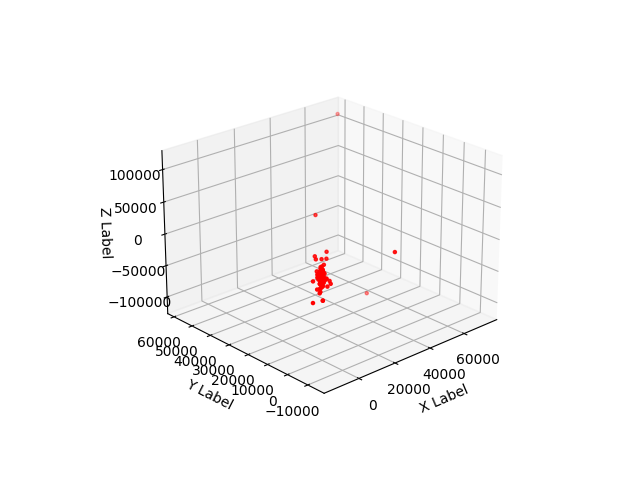

In [14]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='r', marker='o', s=5)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

<IPython.core.display.Javascript object>


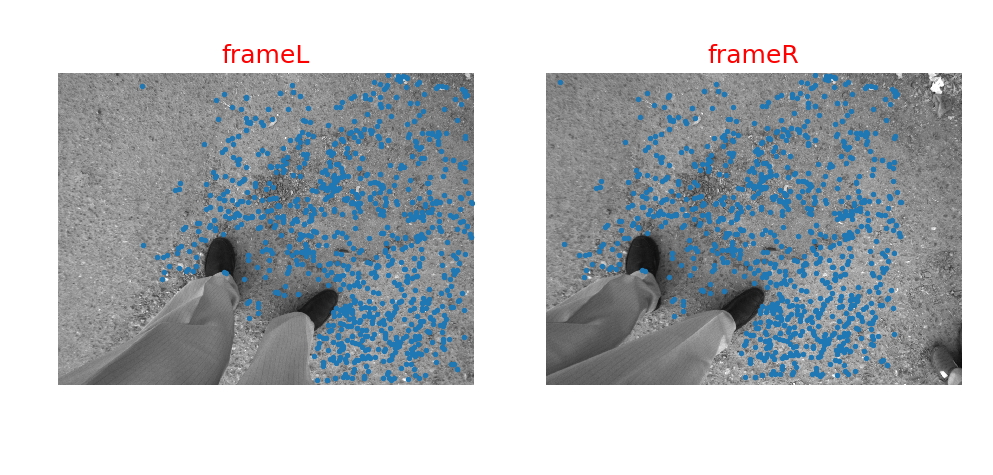

In [55]:
# x, y = zip(*list_kp1)
# plt.scatter(*zip(*list_kp1), s=5)
# plt.imshow(rect_l)
# plt.show

imgs = []
imgs.append(cv2.cvtColor(rect_l, cv2.COLOR_BGR2RGB))
imgs.append(cv2.cvtColor(rect_r, cv2.COLOR_BGR2RGB))

kp_lists = []
kp_lists.append(list_kp1)
kp_lists.append(list_kp2)

row,col = 1,2
f, axarr = plt.subplots(row,col,figsize=(8,5))
f.tight_layout()

axarr[0].imshow(imgs[0]),axarr[0].set_title('frameL', color='r', size=15), axarr[0].axis('off'), axarr[0].scatter(*zip(*kp_lists[0]), s=5)
axarr[1].imshow(imgs[1]),axarr[1].set_title('frameR', color='r', size=15), axarr[1].axis('off'), axarr[1].scatter(*zip(*kp_lists[1]), s=5)

plt.show()